In [59]:
import cv2 as cv

In [60]:
def show_image(image, title:str=None):
    import cv2 as cv
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title)
    plt.show()

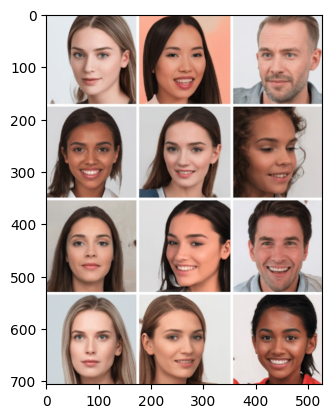

In [61]:
img = cv.imread("faces/faces_12.jpg")
show_image(img)

In [62]:
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")

In [63]:
#help(face_cascade.detectMultiScale)

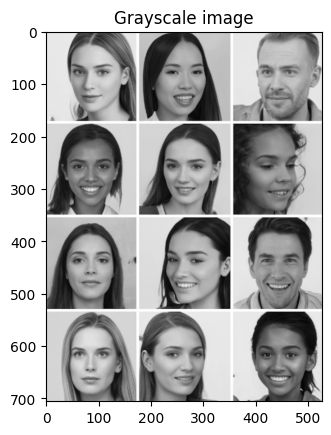

In [64]:
# To enhance detection of any object in pictures, the recommendation is to use grayscale
gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
show_image(gray_image, "Grayscale image")

In [65]:
SCALE_FACTOR = 1.1
MINIMUM_NEIGHBORS = 4
faces = face_cascade.detectMultiScale(gray_image, SCALE_FACTOR, MINIMUM_NEIGHBORS)

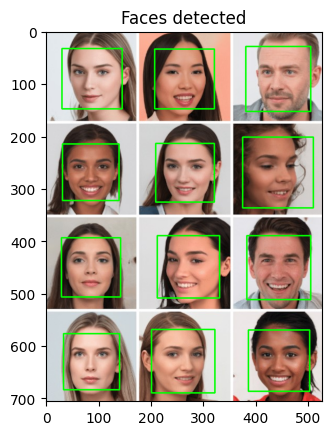

In [66]:
faces_detected = img.copy()
for (global_x, global_y, global_w, global_h) in faces:
    cv.rectangle(
        img = faces_detected, 
        pt1 = (global_x, global_y), 
        pt2 = (global_x+global_w, global_y+global_h), 
        color = (0, 255, 0), 
        thickness = 2)
    
show_image(faces_detected, "Faces detected")

In [73]:
def find_faces(image_path:str, scaleFactor: float=1.1, minNeighbours: int=4):
    import cv2 as cv
    
    if (image := cv.imread(image_path)) is not None:
        cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
        result = image.copy()
        detected = cascade.detectMultiScale(
            image = cv.cvtColor(
                src = image, 
                code = cv.COLOR_BGR2GRAY
            ), 
            scaleFactor = scaleFactor, 
            minNeighbors = minNeighbours
        )
        for (x, y, w, h) in detected:
            cv.rectangle(
                img = result, 
                pt1 = (x, y), 
                pt2 = (x+w, y+h), 
                color = (0, 255, 0), 
                thickness = 2)
            
        return result, len(detected)
    else:
        raise ValueError(f"Image not found: {image_path}")
    

In [78]:
def show_with_count(detection_result):
    show_image(detection_result[0], f"Faces detected: {detection_result[1]}")

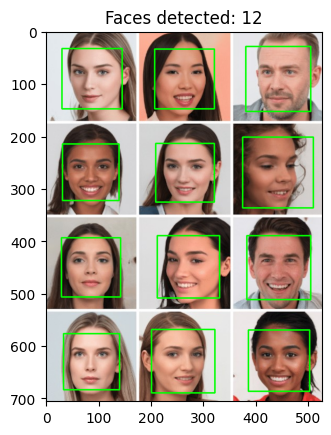

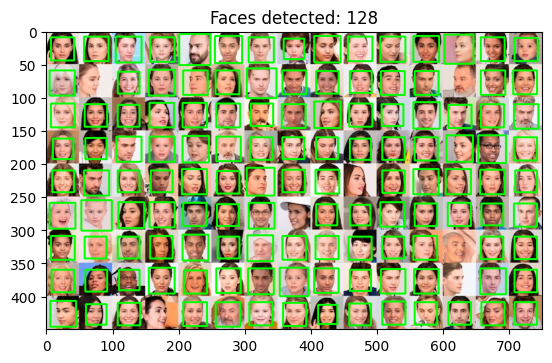

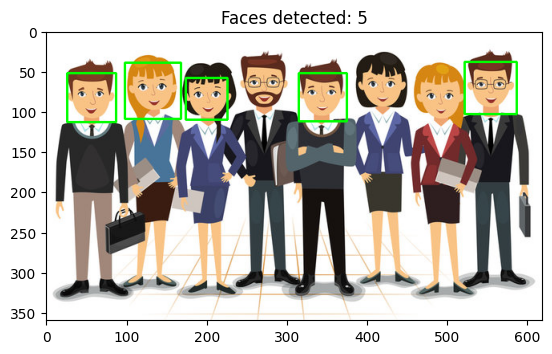

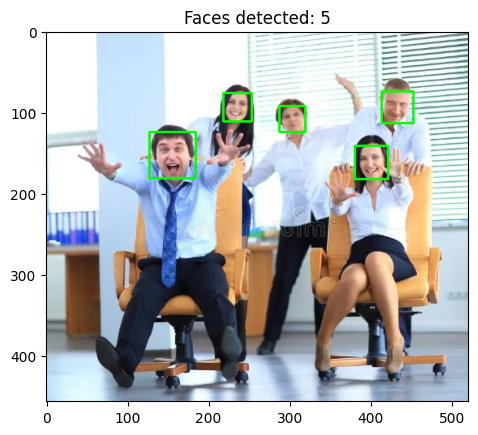

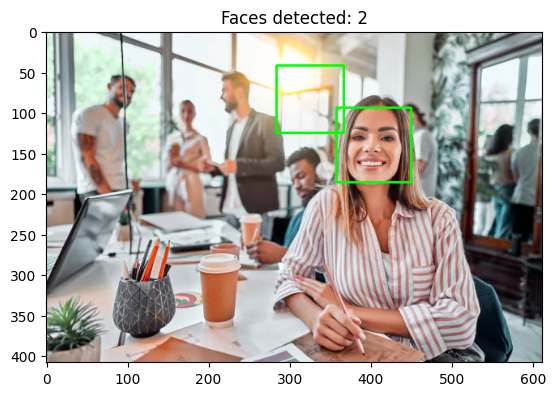

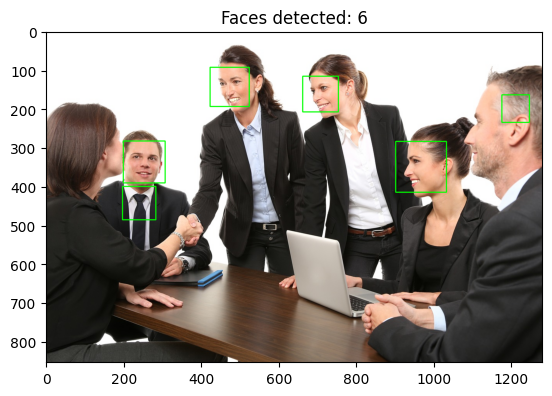

In [79]:
show_with_count(find_faces("faces/faces_12.jpg"))
show_with_count(find_faces("faces/ai-faces-1.jpg"))
show_with_count(find_faces("faces/cartoon_faces.jpg"))
show_with_count(find_faces("faces/happy_team.jpg"))
show_with_count(find_faces("faces/multifaces.jpg"))
show_with_count(find_faces("faces/meeting.jpg"))

In [167]:
def get_fg(image, detected_list, accuracy:int):
    import cv2 as cv
    import numpy as np
#    print(f"your OpenCV version is {cv.__version__}")
    margin_y = 30
    margin_x = 10
    L_ITERATIONS = accuracy # = epochs in ANN
    i_modes = [cv.GC_INIT_WITH_RECT, cv.GC_INIT_WITH_MASK]
    i_flagged_mask = []
    print(f"Found {len(detected_list)} faces")
    for (x,y,w,h) in detected_list:
        i_rect = ((x - margin_x),(y - margin_y),(w + margin_x),(h + margin_y))
        i_mask = np.zeros(image.shape[:2],np.uint8)
        i_bg_model = np.zeros((1,65),np.float64)
        i_fg_model = np.zeros((1,65),np.float64)
        cv.grabCut(
            img = image,
            mask = i_mask,
            rect = i_rect,
            bgdModel = i_bg_model,
            fgdModel = i_fg_model,
            iterCount = L_ITERATIONS,
            mode = i_modes[0])
        i_flagged_mask.append(np.where((i_mask==2)|(i_mask==0),0,1).astype('uint8'))
    
    composite_mask = np.zeros(image.shape[:2],np.uint8)
    
    for i in i_flagged_mask:
        composite_mask = np.where( (composite_mask==1) | (i==1),1,0).astype('uint8')
    
    local_image = image * composite_mask[:,:,np.newaxis]
    return local_image
    
def isolate_face(image_path:str, scaleFactor: float=1.1, minNeighbours: int=4):
    import cv2 as cv
    
    if (image := cv.imread(image_path)) is not None:
        cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
        result = image.copy()
        detected = cascade.detectMultiScale(
            image = cv.cvtColor(
                src = image, 
                code = cv.COLOR_BGR2GRAY
            ), 
            scaleFactor = scaleFactor, 
            minNeighbors = minNeighbours
        )
        return get_fg(image,detected,accuracy=5)
        
    else:
        raise ValueError(f"Image not found: {image_path}")

Found 12 faces


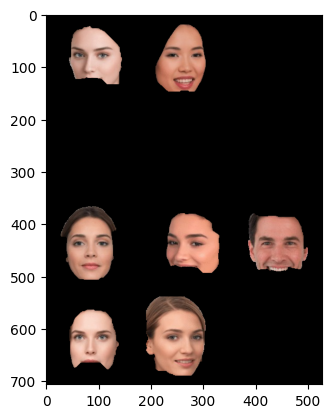

In [168]:
show_image(isolate_face("faces/faces_12.jpg"))